In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

In [ ]:
plt.style.use('default')
sns.set_theme(style="whitegrid")

# 2. Force Global Parameters to Black
plt.rcParams.update({
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

In [ ]:
df = pd.read_csv('NCHS_-_Potentially_Excess_Deaths_from_the_Five_Leading_Causes_of_Death.csv')
df

In [ ]:

sns.histplot(
    data=df[['Observed Deaths','Expected Deaths','Potentially Excess Deaths']], 
    kde=True,
    bins=30,
    color='#1f77b4'
)

In [ ]:
df.isnull().sum()

In [ ]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [ ]:
df.isnull().sum()

In [ ]:
df

In [ ]:
count_df = df[df['Locality'] == 'All'].copy()
cause_counts = count_df['Cause of Death'].value_counts().reset_index()
cause_counts.columns = ['Cause of Death', 'Record Count']
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cause_counts, 
    x='Record Count', 
    y='Cause of Death', 
    hue='Cause of Death',
    palette='flare', 
    legend=False   
)
for i, v in enumerate(cause_counts['Record Count']):
    plt.text(v, i, f' {v}', va='center', fontweight='bold')

plt.title('Distribution of Data Records by Cause of Death', fontsize=14)
plt.xlabel('Number of Records')
plt.show()

In [ ]:
sc_cols = ['Observed Deaths', 'Expected Deaths','Potentially Excess Deaths','Percent Potentially Excess Deaths']
sc_pca = StandardScaler()

sc_data = sc_pca.fit_transform(df[sc_cols])

In [ ]:
sc_df = pd.DataFrame(sc_data,columns = sc_cols)

In [ ]:
sc_df

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(sc_data)

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'], index=sc_df.index)

In [ ]:
pca_df

In [ ]:

sns.histplot(
    data=pca_df[['PC1','PC2']], 
    kde=True,
    bins=30,
    color='#1f77b4'
)

In [ ]:
df.drop(sc_cols,axis=1,inplace=True)

In [ ]:
df

In [ ]:
df = pd.concat([df,pca_df],axis=1)

In [ ]:
df

In [ ]:
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Cause of Death', 
    data=df, 
    alpha=0.6, 
    palette='viridis'
)
plt.title('PC1 vs PC2 by Cause of Death', fontsize=15)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df['Population_log'] = np.log1p(df['Population'])
sc_pop = StandardScaler()
df['Population_scaled_log'] = sc_pop.fit_transform(df[['Population_log']])

In [ ]:
df.drop(['Population','Population_log'],axis=1,inplace=True)

In [ ]:
df.columns.tolist()

In [ ]:
sns.histplot(
    data=df['Population_scaled_log'], 
    kde=True,
    bins=30,
    color='#1f77b4'
)

In [ ]:
lb = LabelEncoder()

df['Cause_of_Death_Encoded'] = lb.fit_transform(df['Cause of Death'])


target_class_names = lb.classes_
print("Encoded Label Mapping:", target_class_names)

In [ ]:
df.drop(['State','State FIPS Code'],axis=1,inplace=True)

In [ ]:
df['HHS Region'] = df['HHS Region'].astype(str)
cat_cols = ['HHS Region','Benchmark','Age Range','Locality']

ohe_cat_cols = pd.get_dummies(df[cat_cols],drop_first=True)

In [ ]:
ohe_cat_cols

In [ ]:
df = df.drop(['HHS Region','Age Range','Benchmark','Locality','Cause of Death'],axis=1)

df = pd.concat([df,ohe_cat_cols],axis=1)

In [ ]:
df

In [ ]:
df.columns.tolist()

In [ ]:
sc_year = StandardScaler()
df['Year_Encoded'] = sc_year.fit_transform(df[['Year']])
df['Year_Encoded']

In [ ]:
df.drop('Year',axis=1,inplace=True)

In [ ]:
df.columns.tolist()

In [ ]:
X = df.drop('Cause_of_Death_Encoded',axis=1)
y = df['Cause_of_Death_Encoded']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

dt = DecisionTreeClassifier(max_depth=10, random_state = 42)
dt.fit(X_train, y_train)

y_test_pred_dtc = dt.predict(X_test)

print(list(X.columns))

In [ ]:
print(accuracy_score(y_test,y_test_pred_dtc))

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=20)
rfc.fit(X_train, y_train)

y_test_pred_rfc = rfc.predict(X_test)

print(accuracy_score(y_test,y_test_pred_rfc))
print(classification_report(y_test,y_test_pred_rfc))

In [ ]:
labels=[0,1,2,3]
cm = confusion_matrix(y_test, y_test_pred_rfc,labels=labels)

# 2. Plotting

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Low', 'Med', 'High', 'Extreme'],
            yticklabels=['Low', 'Med', 'High', 'Extreme'])

plt.title('FREQUENCY ANALYSIS: LEADING CAUSES OF DEATH', 
          color='#D4AF37', fontsize=22, family='serif', fontweight='bold', pad=30)
plt.xlabel('Predicted Risk')
plt.ylabel('Actual Risk')
plt.show()

In [ ]:

xg = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    #use_label_encoder=False,
    eval_metric = 'merror',
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xg.fit(X_train,y_train)
y_test_pred_xg = xg.predict(X_test)

print(accuracy_score(y_test,y_test_pred_xg))
print(classification_report(y_test,y_test_pred_xg))

In [ ]:
labels=[0,1,2,3]
cm = confusion_matrix(y_test, y_test_pred_xg,labels=labels)

# 2. Plotting

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Med', 'High', 'Extreme'],
            yticklabels=['Low', 'Med', 'High', 'Extreme'])

plt.title('FREQUENCY ANALYSIS: LEADING CAUSES OF DEATH', 
          color='#D4AF37', fontsize=22, family='serif', fontweight='bold', pad=30)
plt.xlabel('Predicted Risk')
plt.ylabel('Actual Risk')
plt.show()

In [ ]:
gb = GaussianNB()
gb.fit(X_train,y_train)

y_test_pred_gb = gb.predict(X_test)

print(accuracy_score(y_test,y_test_pred_gb))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

y_test_pred_knn = knn.predict(X_test)

print(accuracy_score(y_test,y_test_pred_knn))

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=1000, solver = 'newton-cg')
lr.fit(X_train,y_train)

y_test_pred_lr = lr.predict(X_test)

print(accuracy_score(y_test,y_test_pred_lr))

In [ ]:
df

In [ ]:
df.head().columns

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rfc = {
    'n_estimators': [100, 200,300],
    'max_depth': [10, 15, 20, None], 
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

rfc = RandomForestClassifier(random_state=42)

random_search_rfc = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_grid_rfc,
    n_iter=20,
    cv=5,
    scoring='accuracy',  
    verbose=2,
    random_state=42,
    n_jobs=-1  


random_search_rfc.fit(X_train, y_train)

print("Best Parameters:", random_search_rfc.best_params_)
print("Best Accuracy Score:", random_search_rfc.best_score_)

rfc_tuned = random_search_rfc.best_estimator_


# output->

'''
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.8505503755503755
'''

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy Score: 0.848976948976949


"\nFitting 5 folds for each of 20 candidates, totalling 100 fits\nBest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}\nBest Accuracy Score: 0.8505503755503755\n"

---- Top 10 Feature Importances (Randomized Search CV)----
PC1                         0.302183
PC2                         0.237620
Population_scaled_log       0.199140
Year_Encoded                0.061993
Benchmark_Floating          0.013736
Benchmark_2010 Fixed        0.013403
Locality_Nonmetropolitan    0.012842
Age Range_0-84              0.012297
Age Range_0-79              0.012087
Age Range_0-74              0.011123
dtype: float64


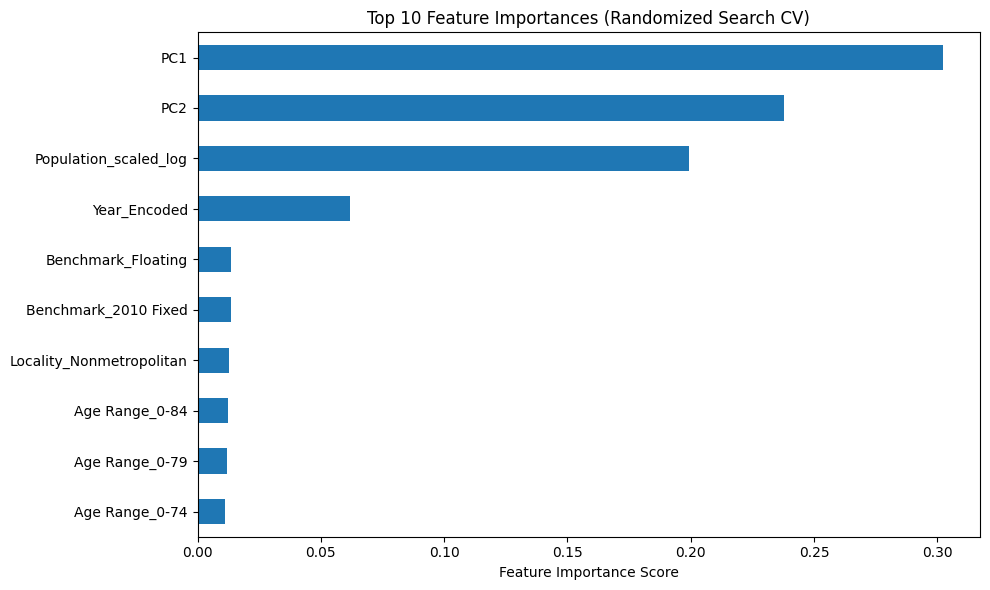

In [42]:
features_import = pd.Series(rfc_tuned.feature_importances_, index = X_train.columns)
top_10 = features_import.nlargest(10)
print("---- Top 10 Feature Importances (Randomized Search CV)----")
print(top_10)

plt.figure(figsize=(10,6))
top_10.sort_values(ascending=True).plot(kind='barh')
plt.title('Top 10 Feature Importances (Randomized Search CV)')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.savefig('top_10_feature_importances_(Randomized Search CV)')

In [49]:
rfc_final = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20,    
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42, 
    n_jobs=-1       
)

rfc_final.fit(X_train, y_train) 
print("Model fitting successful.")



Model fitting successful.


In [50]:
import joblib
joblib.dump(rfc_final, 'rfc_tuned.joblib',compress=9)

['rfc_tuned.joblib']

In [ ]:
print("\n--- Dumping 6 assets to joblib files ---")
try:
   
    joblib.dump(rfc_final, 'rfc_tuned.joblib')     

    joblib.dump(lb, 'label_encoder.joblib') 
    
    joblib.dump(pca, 'pca_object.joblib') 

    joblib.dump(sc_pca, 'scaler_pca.joblib') 
    
    joblib.dump(sc_pop, 'scaler_pop.joblib') 

    joblib.dump(sc_year, 'scaler_year.joblib') 

    print("SUCCESS: All 6 required models and transformers saved successfully!")
    print("\nYour Streamlit app should now run successfully.")
    
except NameError as e:
    print(f"CRITICAL ERROR: A required variable ({e}) is missing. Please ensure all scalers, PCA, and the LabelEncoder are fitted and defined in preceding cells.")

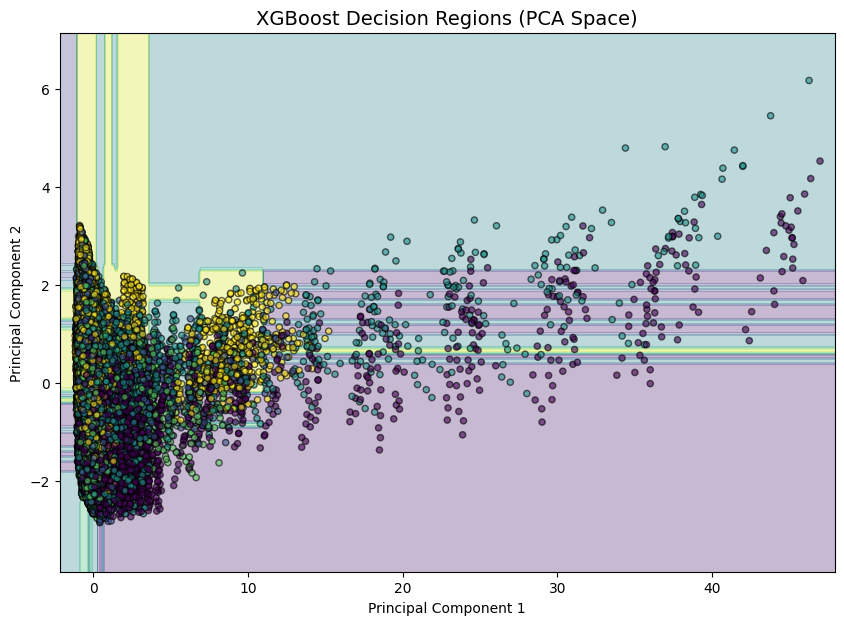

In [72]:
from sklearn.decomposition import PCA
import numpy as np

# 1. Reduce data to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train) # Standardized X_train

# 2. Re-train a simple XGB model on these 2 components just for visualization
xg_viz = XGBClassifier(n_estimators=100, max_depth=5)
xg_viz.fit(X_train_pca, y_train)

# 3. Create a mesh grid to plot boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# 4. Predict across the grid
Z = xg_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 5. Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, s=20, edgecolor='k', alpha=0.6, cmap='viridis')

plt.title('XGBoost Decision Regions (PCA Space)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()